In [1]:
include("dsm.jl")
import dsm
import PyPlot

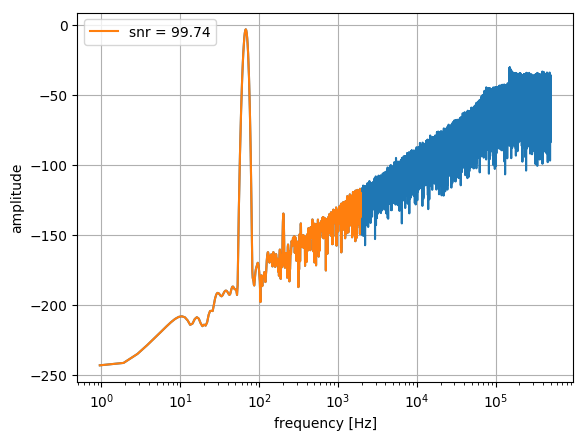

In [2]:
f_s = 1e6;
T_s = 1/f_s;

n_fft = 2^20;
n_ini = 2^16;
k = 71;

f_i = f_s/n_fft*k;
a_i = .7;
b_i = 0;

n_i = 0;

t = 0:T_s:T_s*(n_fft+n_ini-1);
inp = a_i*sin.(2*pi*f_i*t) + b_i + n_i*randn(size(t));

mod = dsm.mod_so(1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0);
out = dsm.sim_mod(mod, inp);

q = out.q[end-n_fft+1:end];
q_snr = dsm.snr(q, f_i, f_s/(2*256), f_s);

w = DSP.Windows.kaiser(n_fft, 20);
wf = mean(w);
Y_inp = fft(q.*w)/n_fft/wf;

f = linspace(0, f_s/2, (n_fft/2+1));

PyPlot.semilogx(f, 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/2+1)])));
PyPlot.hold(true);
PyPlot.semilogx(f[1:trunc(Int64, n_fft/(2*256))], 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/(2*256))])), label=@sprintf("snr = %.2f", q_snr))
PyPlot.legend(loc=2);
PyPlot.hold(false);
PyPlot.grid(true);
PyPlot.xlabel("frequency [Hz]");
PyPlot.ylabel("amplitude");

In [3]:
q_0 = out.q;

cic_r = 256;
cic_m = 2;
cic_n = 3;

cic_int_1 = zeros(size(q_0));
cic_int_2 = zeros(size(q_0));
cic_int_3 = zeros(size(q_0));
cic_dec   = zeros(length(q_0)/cic_r+1);
cic_dif_1 = zeros(length(q_0)/cic_r+1);
cic_dif_2 = zeros(length(q_0)/cic_r+1);
cic_dif_3 = zeros(length(q_0)/cic_r+1);
t_dec     = zeros(length(q_0)/cic_r+1);

c = 0;
k = cic_m;
for i = 2:length(q_0)
    cic_int_1[i] = cic_int_1[i-1] + q_0[i];
    cic_int_2[i] = cic_int_2[i-1] + cic_int_1[i];
    cic_int_3[i] = cic_int_3[i-1] + cic_int_2[i];
    c = c + 1;
    if c == cic_r
        c = 0;
        k = k + 1;
        t_dec[k] = t[i];
        cic_dec[k] = cic_int_3[i];
        cic_dif_1[k] = cic_dec[k] - cic_dec[k-cic_m];
        cic_dif_2[k] = cic_dif_1[k] - cic_dif_1[k-cic_m];
        cic_dif_3[k] = cic_dif_2[k] - cic_dif_2[k-cic_m];
    end
end

k = (cic_r*cic_m)^cic_n;
cic_out = cic_dif_3[trunc(Int64, end-n_fft/cic_r+1):end]/k;

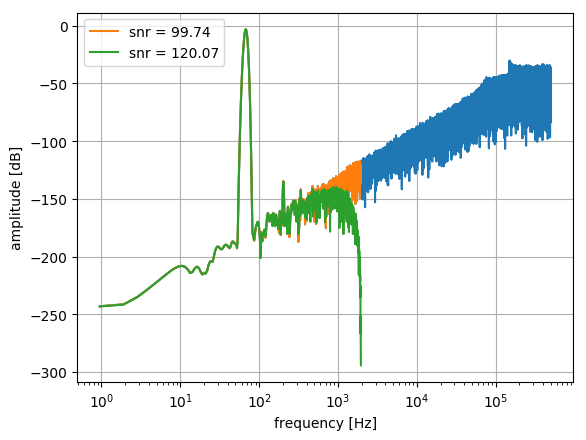

In [4]:
cic_n_fft = trunc(Int64, n_fft/cic_r);
w = DSP.Windows.kaiser(cic_n_fft, 20);
wf = mean(w);
Y_cic = fft(cic_out.*w)/cic_n_fft/wf;

f_cic = linspace(0, f_s/2/cic_r, (cic_n_fft/2+1));

cic_snr = dsm.snr(cic_out, f_i, f_s/(2*256), f_s/256);

PyPlot.semilogx(f, 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/2+1)])));
PyPlot.hold(true);
PyPlot.semilogx(f[1:trunc(Int64, n_fft/(2*256))], 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/(2*256))])), label=@sprintf("snr = %.2f", q_snr));
PyPlot.semilogx(f_cic, 20*log10.(2*abs.(Y_cic[1:trunc(Int64, cic_n_fft/2+1)])), label=@sprintf("snr = %.2f", cic_snr));
PyPlot.legend(loc=2)
PyPlot.hold(false);
PyPlot.grid();
PyPlot.xlabel("frequency [Hz]");
PyPlot.ylabel("amplitude [dB]");